## This Notebook handels the EMG hand gesture dataset 

Dataset can be found here: https://zenodo.org/record/7637557#.Y-q0gXbMK3A

"LSTM Recurrent Neural Network for Hand Gesture Recognition Using EMG Signals" by Toro-Ossaba, Jaramillo-Tigreros

In [256]:
abspath = "C:/Users/Finn/Documents/PlexoMotion/EMG_data/EMG hand gesture dataset"

In [257]:
# read data of the 8 subject each performing 4 gestures 
import pandas as pd 
from itertools import permutations

def read_data(subject, gesture): 
    df = pd.read_csv(abspath + "/subject " + str(subject)+ "/" + str(gesture) + ".txt", 
                     delimiter="\t", 
                     header=None, names=["Channel {}".format(x) for x in range(1, 5)])
    df["class"] = gesture
    df["subject"] = subject
    return df

n_gestures = 5
n_subjects = 8
data = pd.concat([read_data(x, y) for x in range(1, n_subjects+1) for y in range(n_gestures)], ignore_index=True)
data

,Channel 1,Channel 2,Channel 3,Channel 4,class,subject
0,0.012060,0.007172,-0.004912,-0.010352,0,1
1,0.009734,0.002081,-0.005152,-0.015085,0,1
2,0.009581,0.001323,0.000032,-0.014105,0,1
3,0.008355,0.006496,0.000987,-0.011838,0,1
4,0.005473,0.002169,0.004220,-0.009029,0,1
...,...,...,...,...,...,...
822686,0.005349,0.051188,-0.004612,-0.078479,4,8
822687,-0.003400,0.045711,-0.031460,0.057762,4,8
822688,-0.008356,0.027660,-0.006860,0.065028,4,8
822689,-0.014089,0.010258,0.007897,-0.051703,4,8


In [258]:
# dividing each gesture-dataset in windows of 200 samples making 100 windows per gesture, 
# because each subject performs 5 gestures 500 windows per subject are reached 
# going to numpy for 3-d arrays 
import numpy as np 
from numpy.lib.stride_tricks import sliding_window_view

def window_data(array, length=200, step=None): 
    """ Please make sure sensors are on col, time in row """
    if step is None: 
        step = length
    # assert array.shape[0]%length == 0
    rows, cols = array.shape
    return sliding_window_view(array, (length, cols))[::step, 0]

# x containing the independant variables, while 
# t contatin the dependent variables of each gestures/subject (8 * 5)
x, t = [], []
for item in [window_data(data[(data["class"]==cls) & (data["subject"]==sbj)]) 
             for cls in range(n_gestures) for sbj in range(1, n_subjects+1)]: 
    x.append(item[:, :, :4])
    t.append(item[0, 0, 4:])


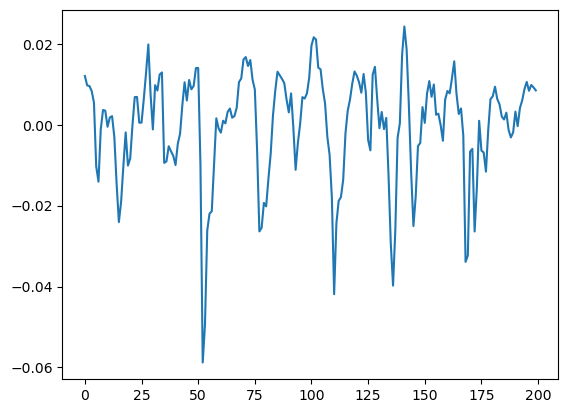

In [259]:
# plot one window 
import matplotlib.pyplot as plt 

plt.plot(x[0][0, :, 0])

In [260]:
# preprocessing on x 
def absolut(ary): 
    return abs(ary)

In [261]:
def moving_average(ary, delay=20): 
    """
    moving average on a given time window with delay as specified, returns array
    """
    # leading and past zeros 
    ary = np.abs(ary)
    zeros = np.zeros((ary.shape[0], delay, ary.shape[2]))
    ary = np.hstack([zeros, ary, zeros])
    # iterate over windows 
    data = []
    for win in ary: 
        data.append(np.mean(sliding_window_view(win, window_shape=(delay, 4))[:, 0], axis=1))
    return np.concatenate([x.reshape((1,) + x.shape) for x in data], axis=0)

In [262]:
def normalize(ary): 
    """
    normalize to values between 0 and 1 on each window
    """
    data = []
    for win in ary: 
        data.append(win/np.max(win))
    return np.concatenate([x.reshape((1,) + x.shape) for x in data], axis=0)

In [263]:
# preprocessing as pipeline 
pre_pipeline = [absolut, moving_average, normalize]
z = []

for var in x: 
    for fun in pre_pipeline: 
        var = fun(var)
    z.append(var)
    
lengths = [len(i) for i in z]
targets = np.repeat(np.array([n[0] for n in t]), lengths)
subjects = np.repeat(np.array([n[1] for n in t]), lengths)
x = np.vstack(z)
x.shape, targets.shape, subjects.shape

((4095, 221, 4), (4095,), (4095,))

(3.0, 6.0)

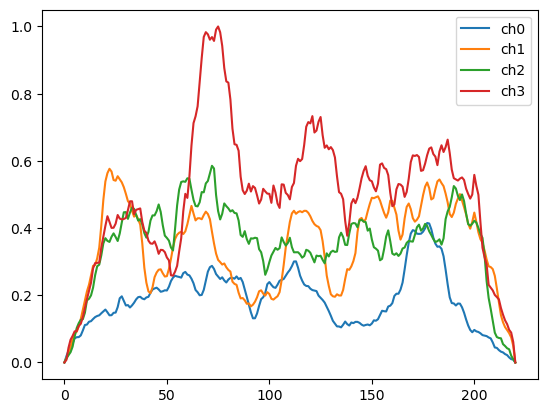

In [264]:
plt.plot(x[3011, :, :])
plt.legend(["ch" + str(x) for x in range(5)])
targets[3011], subjects[3011]

## LSTM 

reshape independant variables to 2d-array in random order with rows: timesteps, cols: emg-channel. Plus targets 

In [265]:
np.random.seed(5)
assert len(targets) == len(subjects) == len(x)
shuffle_idx = np.random.permutation(range(len(targets)))

cur_idx = np.where(shuffle_idx == 3011)[0][0]
cur_idx

858

In [266]:
targets = targets[shuffle_idx]
subjects = subjects[shuffle_idx]
x = x[shuffle_idx]

x_train, x_test = x[:(n:=int(len(x) * 0.8))], x[n:]
targets_train, targets_test = targets[:n], targets[n:]
x_train.shape, x_test.shape, targets_train.shape, targets_test.shape

((3276, 221, 4), (819, 221, 4), (3276,), (819,))

In [267]:
targets_train = np.repeat(targets_train, x.shape[1]).reshape(-1, 1)
targets_test = np.repeat(targets_test, x.shape[1]).reshape(-1, 1)

# subjects = np.repeat(subjects, x.shape[1]).reshape(-1, 1)

x_train = x_train.reshape(-1, x.shape[2])
x_test = x_test.reshape(-1, x.shape[2])

x_train.shape, targets_train.shape, x_test.shape, targets_test.shape

((723996, 4), (723996, 1), (180999, 4), (180999, 1))

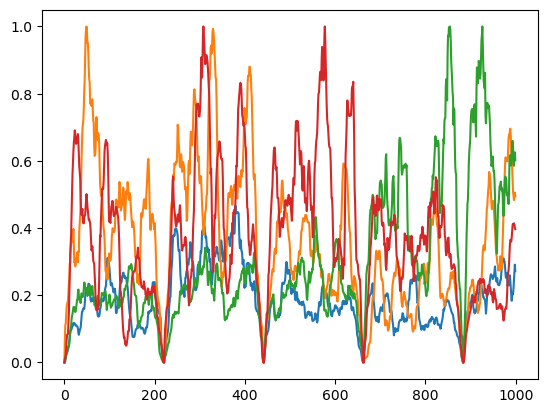

In [268]:
plt.plot(x_train[:1000])

In [269]:
# one hot encode targets 
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
targets_train_hot = encoder.fit_transform(targets_train).toarray()
targets_test_hot = encoder.transform(targets_test).toarray()

In [279]:
from keras import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(Dense(32, activation="relu", input_shape=(4, 1)))
model.add(LSTM(16, activation="relu"))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [280]:
history = model.fit(x_train, targets_train_hot, epochs=100, batch_size=20, shuffle=False)

Epoch 1/100
36200/36200 [==============================] - 63s 2ms/step - loss: 1.2254 - accuracy: 0.4521
Epoch 2/100
36200/36200 [==============================] - 62s 2ms/step - loss: 1.0923 - accuracy: 0.5208
Epoch 3/100
36200/36200 [==============================] - 60s 2ms/step - loss: 1.0747 - accuracy: 0.5312
Epoch 4/100
36200/36200 [==============================] - 60s 2ms/step - loss: 1.0663 - accuracy: 0.5359
Epoch 5/100
36200/36200 [==============================] - 61s 2ms/step - loss: 1.0622 - accuracy: 0.5378
Epoch 6/100
36200/36200 [==============================] - 61s 2ms/step - loss: 1.0594 - accuracy: 0.5390
Epoch 7/100
36200/36200 [==============================] - 2248s 62ms/step - loss: 1.0572 - accuracy: 0.5401
Epoch 8/100
 8683/36200 [======>.......................] - ETA: 52s - loss: 1.0599 - accuracy: 0.5379

KeyboardInterrupt: 

In [120]:
x_train, x_test = x[:(n:=int(0.8 * len(x)))], x[n:]
y_train, y_test = targets[:n], targets[n:]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3276, 221, 4), (3276,), (819, 221, 4), (819,))

In [121]:
encoder = OneHotEncoder()
y_train_hot = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_hot = encoder.transform(y_test.reshape(-1, 1)).toarray()
y_test_hot

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [143]:
from keras import Sequential
import tensorflow as tf
from keras.layers import LSTM, Dense

inputs = tf.keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
# x = LSTM(8, activation="relu", input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True)(inputs)
x = LSTM(8, activation="relu")(inputs)
out_class = Dense(5, activation="softmax", name="class_out")(x)

model = tf.keras.Model(inputs=inputs, outputs=[out_class])

model.compile(loss="categorical_crossentropy", 
             optimizer="adam", 
             metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 221, 4)]          0         
                                                                 
 lstm_19 (LSTM)              (None, 8)                 416       
                                                                 
 class_out (Dense)           (None, 5)                 45        
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [145]:
history = model.fit(x_train, y_train_hot, epochs=100, batch_size=20, validation_data=(x_test, y_test_hot), shuffle=False)

Epoch 1/100
164/164 [==============================] - 8s 47ms/step - loss: 1.5845 - accuracy: 0.3611 - val_loss: 1.5813 - val_accuracy: 0.3932
Epoch 2/100
164/164 [==============================] - 7s 45ms/step - loss: 1.5788 - accuracy: 0.3953 - val_loss: 1.5760 - val_accuracy: 0.4286
Epoch 3/100
164/164 [==============================] - 8s 46ms/step - loss: 1.5733 - accuracy: 0.4051 - val_loss: 1.5708 - val_accuracy: 0.4310
Epoch 4/100
164/164 [==============================] - 7s 46ms/step - loss: 1.5681 - accuracy: 0.4090 - val_loss: 1.5657 - val_accuracy: 0.4103
Epoch 5/100
164/164 [==============================] - 7s 46ms/step - loss: 1.5630 - accuracy: 0.4197 - val_loss: 1.5608 - val_accuracy: 0.4042
Epoch 6/100
164/164 [==============================] - 7s 46ms/step - loss: 1.5579 - accuracy: 0.4176 - val_loss: 1.5559 - val_accuracy: 0.4103
Epoch 7/100
164/164 [==============================] - 7s 45ms/step - loss: 1.5530 - accuracy: 0.4197 - val_loss: 1.5511 - val_accuracy:

164/164 [==============================] - 7s 46ms/step - loss: 1.3917 - accuracy: 0.4179 - val_loss: 1.3950 - val_accuracy: 0.4151
Epoch 58/100
164/164 [==============================] - 8s 46ms/step - loss: 1.3894 - accuracy: 0.4170 - val_loss: 1.3930 - val_accuracy: 0.4139
Epoch 59/100
164/164 [==============================] - 8s 46ms/step - loss: 1.3871 - accuracy: 0.4164 - val_loss: 1.3910 - val_accuracy: 0.4139
Epoch 60/100
164/164 [==============================] - 7s 46ms/step - loss: 1.3849 - accuracy: 0.4164 - val_loss: 1.3891 - val_accuracy: 0.4164
Epoch 61/100
164/164 [==============================] - 8s 46ms/step - loss: 1.3828 - accuracy: 0.4164 - val_loss: 1.3872 - val_accuracy: 0.4188
Epoch 62/100
164/164 [==============================] - 7s 45ms/step - loss: 1.3806 - accuracy: 0.4145 - val_loss: 1.3854 - val_accuracy: 0.4225
Epoch 63/100
164/164 [==============================] - 8s 46ms/step - loss: 1.3785 - accuracy: 0.4127 - val_loss: 1.3835 - val_accuracy: 0.417